# LSTM을 활용한 주가 예측 모델

이번 튜토리얼 에서는 다음과 같은 **프로세스 파이프라인**으로 주가 예측을 진행합니다.

- FinanceDataReader를 활용하여 주가 데이터 받아오기
- torch Dataset 클래스를 활용하여 주가 데이터 구축
- LSTM 을 활용한 주가 예측 모델 구축

## 필요한 모듈 import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import random

import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
seed = 2023
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
!sudo apt-get install -y fonts-nanum #폰트설치--한글로 결과 보려고
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Password:
sudo: a password is required
Password:

## 데이터 (FinanceDataReader)

**FinanceDataReader**는 주가 데이터를 편리하게 가져올 수 있는 파이썬 패키지입니다.

- [GitHub Repo](https://github.com/FinanceData/FinanceDataReader)

**FinanceDataReader**가 아직 설치 되지 않으신 분들은 아래의 주석을 해제한 후 명령어로 설치해 주시기 바랍니다.

In [69]:
!pip install finance-datareader torchinfo

In [70]:
import FinanceDataReader as fdr

In [71]:
# 삼성전자(005930) 전체 (1998-08-21 ~ 현재)
samsung = fdr.DataReader('005930')

매우 편리하게 삼성전자 주가 데이터를 `DataFrame`형식으로 받아옵니다.

기본 **오름차순 정렬**이 된 데이터임을 알 수 있습니다.

### 컬럼 설명

- `Open`:   시가
- `High`:   고가
- `Low`:    저가
- `Close`:  종가
- `Volume`: 거래량
- `Change`: 대비

In [72]:
samsung

,Open,High,Low,Close,Volume,Change
Date,,,,,,
1999-04-28,1917,1954,1909,1925,608370,NaN
1999-04-29,1917,1917,1819,1820,739553,-0.054545
1999-04-30,1817,1817,1757,1788,1128711,-0.017582
1999-05-03,1798,1800,1770,1785,435785,-0.001678
1999-05-04,1790,1829,1761,1761,554765,-0.013445
...,...,...,...,...,...,...
2023-08-02,70700,71000,69800,69900,13835020,-0.016878
2023-08-03,69900,70200,68500,68800,20087090,-0.015737
2023-08-04,68800,69100,68200,68300,12360193,-0.007267


## 시각화

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51333 (\N{HANGUL SYLLABLE JONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44032 (\N{HANGUL SYLLABLE GA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49340 (\N{HANGUL SYLLABLE SAM}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49457 (\N{HANGUL SYLLABLE SEONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51204 (\N{HANGUL SYLLABLE JEON}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packag

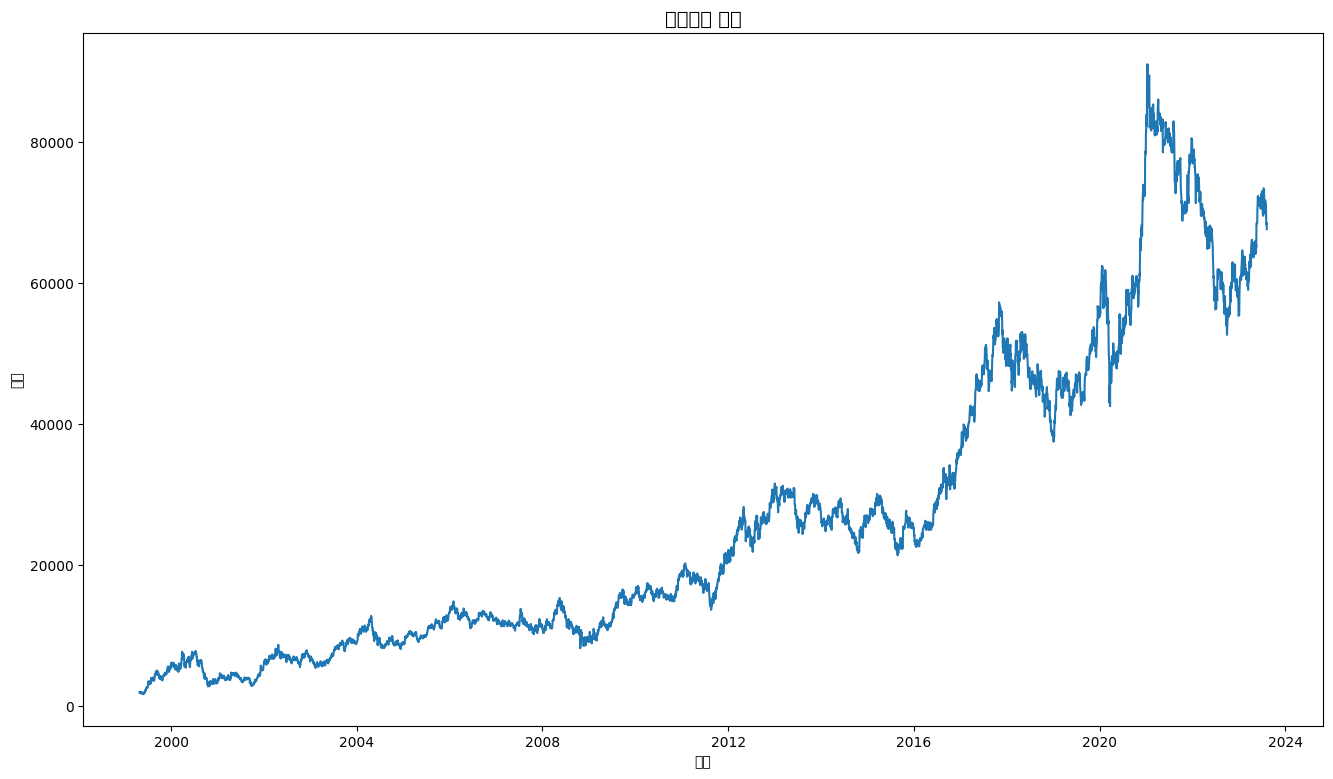

In [73]:
plt.rcParams['font.family'] = 'NanumGothic'

plt.figure(figsize=(16, 9))
plt.title("삼성전자 주가", fontsize=14)
plt.xlabel("날짜")
plt.ylabel("종가")
sns.lineplot(data=samsung, x='Date', y="Close")
plt.show()

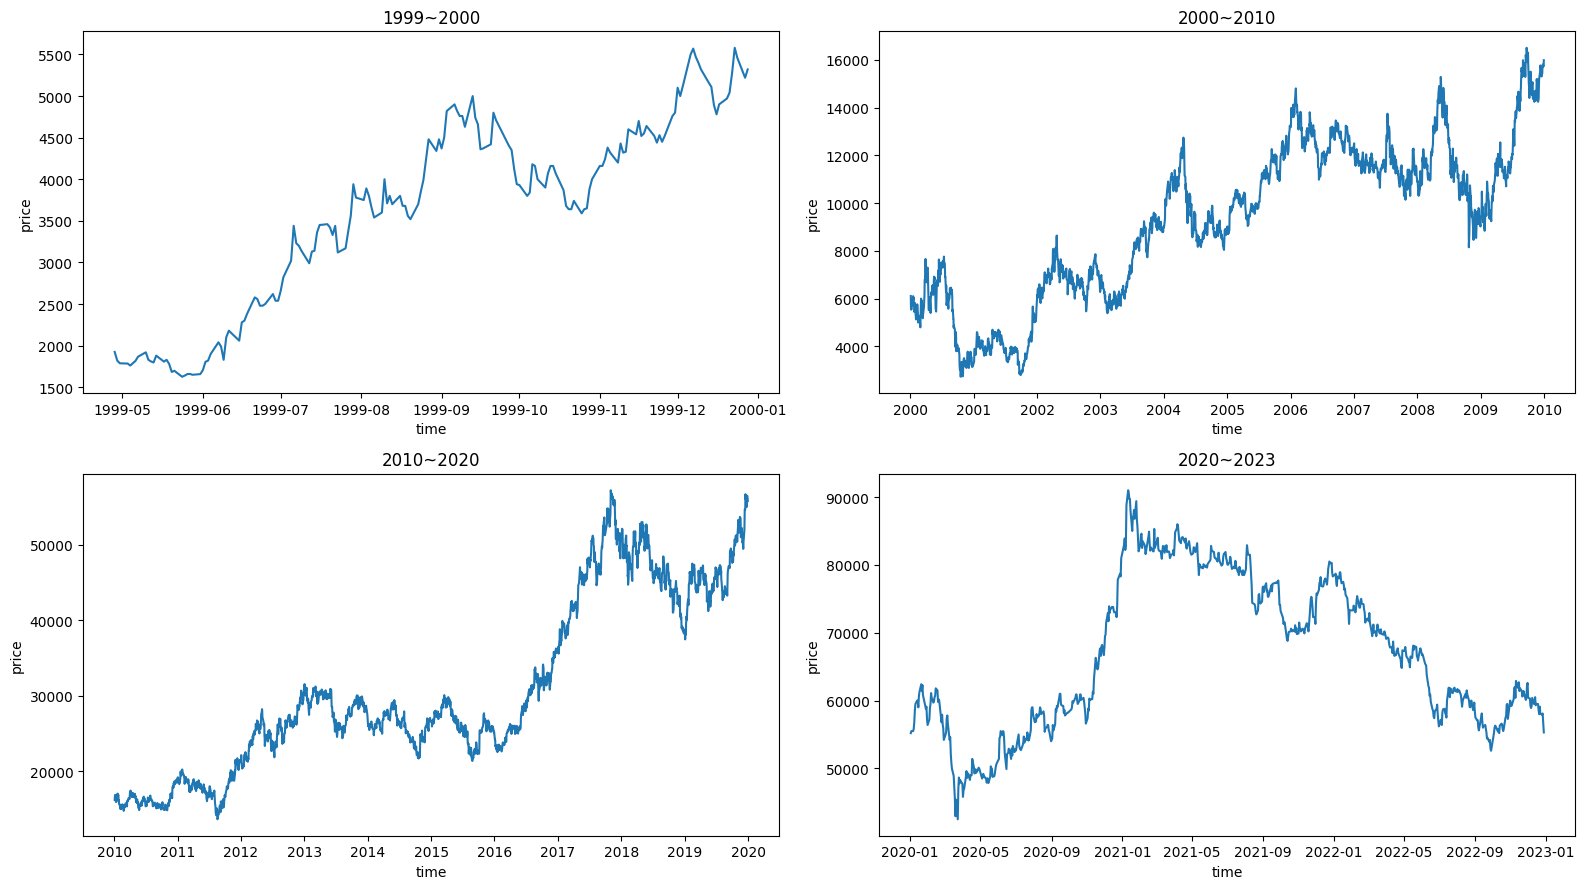

In [74]:
time_steps = [['1999', '2000'],
              ['2000', '2010'],
              ['2010', '2020'],
              ['2020', '2023']] # COVID-19

fig, axes = plt.subplots(2, 2)
fig.set_size_inches(16, 9)
for i in range(4):
    ax = axes[i//2, i%2]
    df = samsung.loc[(samsung.index > time_steps[i][0]) & (samsung.index < time_steps[i][1])]
    sns.lineplot(y=df['Close'], x=df.index, ax=ax)
    ax.set_title(f'{time_steps[i][0]}~{time_steps[i][1]}')
    ax.set_xlabel('time')
    ax.set_ylabel('price')
plt.tight_layout()
plt.show()

## 데이터 전처리

주가 데이터에 대하여 딥러닝 모델이 더 잘 학습할 수 있도록 **정규화(Normalization)**를 해주도록 하겠습니다.

**표준화 (Standardization)**와 **정규화(Normalization)**에 대한 내용은 아래 링크에서 더 자세히 다루니, 참고해 보시기 바랍니다.

- [데이터 전처리에 관하여](https://teddylee777.github.io/scikit-learn/scikit-learn-preprocessing)

In [75]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
y_scaler = MinMaxScaler()
# 스케일을 적용할 column을 정의합니다.
scale_cols = ['Open', 'High', 'Low', 'Volume', 'Close']
#scale_cols = ['Close']
# 스케일 후 columns
scaled = scaler.fit_transform(samsung[scale_cols])
y_scaler.fit(samsung[["Close"]]) ## 나중에 그림그릴 때 inverse하려고
scaled

array([[0.02122924, 0.02018595, 0.02132961, 0.00673675, 0.00334549],
       [0.02122924, 0.01980372, 0.02032402, 0.0081894 , 0.00217065],
       [0.02012182, 0.01877066, 0.01963128, 0.01249871, 0.00181261],
       ...,
       [0.76190476, 0.71384298, 0.76201117, 0.13686985, 0.74601114],
       [0.74972315, 0.71487603, 0.75530726, 0.12145908, 0.74824893],
       [0.7641196 , 0.71384298, 0.75307263, 0.16187477, 0.73817889]])

스케일이 완료된 column으로 새로운 데이터프레임을 생성합니다.

**시간 순으로 정렬**되어 있으며, datetime index는 제외했습니다.

*6,000개의 row, 5개 column*으로 이루어진 데이터셋이 DataFrame으로 정리되었습니다.

In [76]:
df = pd.DataFrame(scaled, columns=scale_cols, index=samsung.index)
df

,Open,High,Low,Volume,Close
Date,,,,,
1999-04-28,0.021229,0.020186,0.021330,0.006737,0.003345
1999-04-29,0.021229,0.019804,0.020324,0.008189,0.002171
1999-04-30,0.020122,0.018771,0.019631,0.012499,0.001813
1999-05-03,0.019911,0.018595,0.019777,0.004826,0.001779
1999-05-04,0.019823,0.018895,0.019676,0.006143,0.001511
...,...,...,...,...,...
2023-08-02,0.782946,0.733471,0.779888,0.153201,0.763913
2023-08-03,0.774086,0.725207,0.765363,0.222433,0.751606
2023-08-04,0.761905,0.713843,0.762011,0.136870,0.746011


## train / val / test 분할

- 2022년 이전까지의 모든 데이터로, 2022년을 val으로, 2023년을 test로.


- 시계열 예측에서는 "예측 당시"에는 미래의 데이터를 모릅니다. 그래서 train 데이터는 무조건 test 데이터보다 시기적으로 **과거**여야합니다.

In [77]:
train =df.loc[(df.index>'2020-01-01')&(df.index<'2022-01-01')]
X_train, y_train = train.drop("Close", axis=1), train.Close
test =df.loc[df.index>='2022-01-01']
X_test, y_test = test.drop("Close", axis=1), test.Close

## Data Preparation

In [78]:
from torch.utils.data import TensorDataset # 텐서데이터셋
from torch.utils.data import DataLoader # 데이터로더

seq_length =10 #hidden_state 개수
batch_size =8   #(batch_size,seq_len,input_dim)

# 데이터셋 생성 함수
def build_dataset(inputs, seq_length):
    dataX = []
    dataY = []
    for i in range(0, len(inputs)-seq_length):
        _x = inputs[i:i+seq_length, :]
        _y = inputs[i+seq_length, [-1]]
        #print(_x, "-->",_y)
        dataX.append(_x)
        dataY.append(_y)

    return np.array(dataX), np.array(dataY)

trainX, trainY =build_dataset(X_train.values,seq_length)
testX, testY =build_dataset(X_test.values,seq_length)

# 텐서로 변환
trainX_tensor = torch.FloatTensor(trainX)
trainY_tensor = torch.FloatTensor(trainY)

testX_tensor = torch.FloatTensor(testX)
testY_tensor = torch.FloatTensor(testY)

# 텐서 형태로 데이터 정의
dataset = TensorDataset(trainX_tensor, trainY_tensor)

# 데이터로더는 기본적으로 2개의 인자를 입력받으며 배치크기는 통상적으로 2의 배수를 사용
dataloader = DataLoader(dataset,
                        batch_size=batch_size,
                        shuffle=False,
                        drop_last=True)  #data개수가 batch개수로 깔끔하게 안나누어떨어질때 마지막 batch버리는것

## Define Model

In [82]:
class LSTM(nn.Module):
    # # 기본변수, layer를 초기화해주는 생성자
    def __init__(self, input_dim, hidden_dim, seq_len, output_dim, layers):
        super().__init__()
        self.hidden_dim=hidden_dim
        self.seq_len=seq_len
        self.output_dim=output_dim
        self.layers=layers

        self.lstm1=nn.LSTM(input_dim,hidden_dim,num_layers=layers,dropout=0.1,batch_first=True) #(8,10,4). ##LSTM layer
       #self.lstm2=nn.LSTM(hidden_dim,5) #multi-layer LSTM
        self.fc=nn.Linear(hidden_dim,output_dim,bias=True) #output_layer(W_hy x h_t)

      # 학습 초기화를 위한 함수. #없어도 갠퓬
    def reset_hidden_state(self):
      self.hiiden=(
              torch.zeros(self.layers,self.seq_len,self.hidden_dim),
              torch.zeros(self.layers,self.seq_len,self.hidden_dim))


    # 예측을 위한 함수
    def forward(self, x):
      x,_status=self.lstm1(x)
      #x,_status=self.lstm2(x)
      x=self.fc(x[:,-1])
      return x

In [83]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [84]:
# 설정값
input_dim =4
hidden_dim =10
output_dim =1
learning_rate =0.01
n_epochs =100
n_layers =1

In [85]:
model =LSTM(input_dim,hidden_dim,seq_length,output_dim,n_layers).to(device)
model

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


LSTM(
  (lstm1): LSTM(4, 10, batch_first=True, dropout=0.1)
  (fc): Linear(in_features=10, out_features=1, bias=True)
)

In [86]:
criterion = nn.MSELoss().to(device)
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

In [87]:
def train_model(model, train_df, n_epochs = None, lr = None, verbose = 10, patience = 10):

    # epoch마다 loss 저장
    train_hist = np.zeros(n_epochs)

    for epoch in range(n_epochs):
        avg_cost = 0
        total_batch = len(train_df)

        for idx, data in enumerate(train_df):

            x_train, y_train = data[0].to(device), data[1].to(device)

            # H(x) 계산
            outputs = model(x_train)

            # cost 계산
            loss = criterion(outputs, y_train)

            # cost로 H(x) 개선
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            avg_cost += loss/total_batch

        train_hist[epoch] = avg_cost

        if epoch % verbose == 0:
            print('Epoch:', '%04d' % (epoch), 'train loss :', '{:.4f}'.format(avg_cost))

        # patience번째 마다 early stopping 여부 확인
        if (epoch % patience == 0) & (epoch != 0):

            # loss가 커졌다면 early stop
            if train_hist[epoch-patience] < train_hist[epoch]:
                print(f'\n Early Stopping at {epoch} epoch.')

                break

    return model.eval(), train_hist

In [88]:
# 모델 학습
model, train_hist = train_model(model, dataloader,
                                n_epochs = n_epochs,
                                lr = learning_rate,
                                verbose = 20,
                                patience = 10)

Epoch: 0000 train loss : 0.0198
Epoch: 0020 train loss : 0.0071
Epoch: 0040 train loss : 0.0068
Epoch: 0060 train loss : 0.0062
Epoch: 0080 train loss : 0.0058


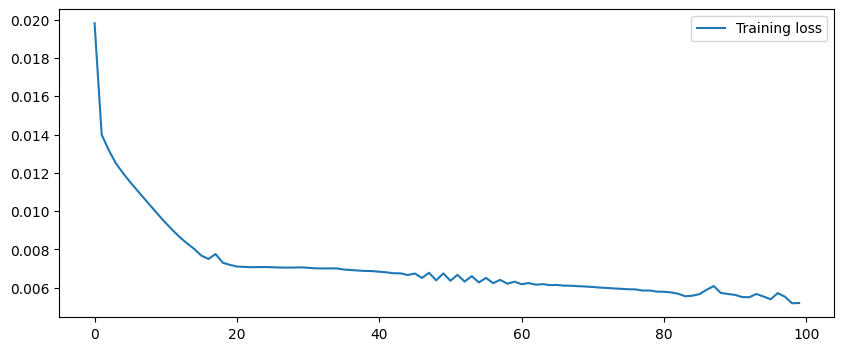

In [89]:
# epoch별 손실값
fig = plt.figure(figsize=(10, 4))
plt.plot(train_hist, label="Training loss")
plt.legend()
plt.show()

## 예측 데이터 시각화

In [90]:
# 텐서 형태로 데이터 정의
testset = TensorDataset(testX_tensor, testY_tensor)

# 데이터로더는 기본적으로 2개의 인자를 입력받으며 배치크기는 통상적으로 2의 배수를 사용
testloader = DataLoader(dataset,
                        batch_size=batch_size,
                        shuffle=False,
                        drop_last=True)

In [91]:
# 예측 테스트
avg_loss = 0.0
preds = []
labels = []

with torch.no_grad():
    ## TO-DO : make prediction and plot graph.
    for data in testloader:
        X_test, y_test = data[0].to(device), data[1].to(device)
        outputs = model(X_test)
        preds.append(outputs.cpu().tolist()) # 그래프를 그리기 위해서 데이터 변형
        labels.append(y_test.cpu().tolist()) # 그래프를 그리기 위해서 데이터 변형

        loss = criterion(outputs, y_test)
        avg_loss += loss

avg_loss = avg_loss / len(testloader)
print("Test MSE : %.4f" % avg_loss)

Test MSE : 0.0062


In [92]:
y_pred = [y_scaler.inverse_transform(pred) for pred in preds]
y_true = [y_scaler.inverse_transform(label) for label in labels]

In [93]:
y_pred = [y.reshape(-1, ) for y in y_pred]
y_true = [y.reshape(-1, ) for y in y_true]

In [94]:
_pred = []
_true = []
for y_hat, y in zip(y_pred, y_true):
    _pred += y_hat.tolist()
    _true += y.tolist()

print(_pred[:5], _true[:5])

[20697.581134080883, 20448.251287221905, 20303.97728836536, 19167.31946533918, 18806.502622336146] [15859.320113718508, 17486.238116830584, 14025.526631206272, 12653.673769935964, 16807.22393855452]


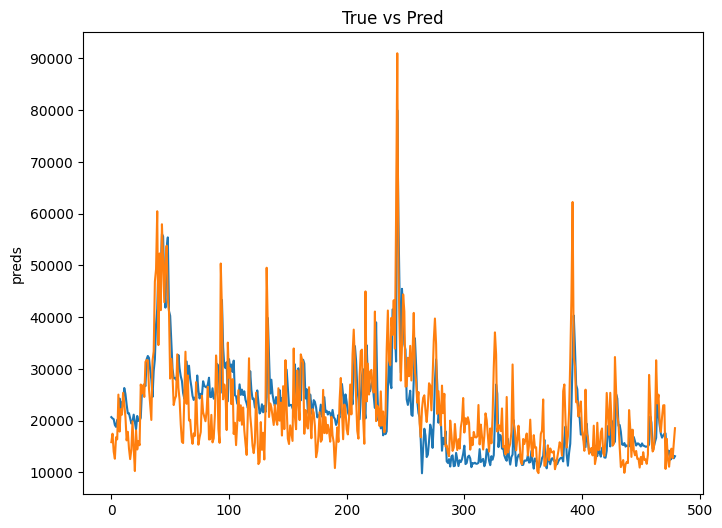

In [95]:
plt.figure(figsize=(8, 6))
df = pd.DataFrame({"preds" : _pred, "labels" : _true})
plt.title("True vs Pred")
sns.lineplot(df.preds)
sns.lineplot(df.labels)
plt.show()